In [25]:
import pandas as pd
import pyarrow as pa
import numpy as np
import gc
import pyarrow.parquet as pq
import missingno as msn

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
#import tsfel
from sklearn.model_selection import train_test_split

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import SMAPE, MAPE, PoissonLoss, QuantileLoss
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Считывание данных

Чтение данных в .parquet кусками в столбцах, одновременное преобразование их из double в float32 и категории, чтобы не перегружать оперативную память

In [4]:
X_train = pq.ParquetFile("X_train.parquet")
y_train = pq.ParquetFile("y_train.parquet")

In [5]:
y_train = y_train.read_row_group(0)

end_frame = []
for column in y_train.column_names:
    if column != 'DT':
        end_frame.append(y_train[column].to_pandas().astype("category"))
    else:
        end_frame.append(y_train[column].to_pandas())
del y_train
y_train = pd.concat(end_frame, axis=1)
del end_frame
gc.collect()

# Resulting dataframe is 1.6 GB

0

In [6]:
y_train.head()

,DT,Y_ЭКСГАУСТЕР А/М №9_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9,Y_ЭКСГАУСТЕР А/М №9_МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_КЛ1 ТР№9 ДО ЭД ЭКСГАУСТЕРА №9,Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_КОРПУС ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_МАСЛООХЛАДИТЕЛЬ М-05-1 ЭКСГ. №9,Y_ЭКСГАУСТЕР А/М №9_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №9,...,Y_ЭКСГАУСТЕР А/М №6_ЭКСГАУСТЕР А/М №6,Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №6,Y_ЭКСГАУСТЕР А/М №6_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ6 ВУ1,Y_ЭКСГАУСТЕР А/М №6_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №6,Y_ЭКСГАУСТЕР А/М №6_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№6,Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.3,Y_ЭКСГАУСТЕР А/М №6_МАСЛОПРОВОДЫ ЭКСГ №6,Y_ЭКСГАУСТЕР А/М №6_КЛ1 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6,Y_ЭКСГАУСТЕР А/М №6_КЛ2 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6,Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.2
0,2019-01-16 13:21:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-16 13:21:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-16 13:21:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-16 13:21:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-16 13:21:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
table = X_train.read_row_group(0)

end_frame = []
for column in table.column_names:
    if column != 'DT':
        end_frame.append(table[column].to_pandas().astype("float32"))
    else:
        end_frame.append(table[column].to_pandas())
del table
df = pd.concat(end_frame, axis=1)
del end_frame
gc.collect()

0

In [8]:
df.head()

,DT,ЭКСГАУСТЕР 4. ТОК РОТОРА 1,ЭКСГАУСТЕР 4. ТОК РОТОРА2,ЭКСГАУСТЕР 4. ТОК СТАТОРА,ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,...,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
0,2019-01-16 13:21:00,363.676666,363.676666,244.078003,119.385002,41.369999,39.750000,39.750000,44.538548,33.259998,...,17.040001,15.410000,6.085000,12.170000,0.040000,0.060000,0.080000,0.100000,0.060000,0.080000
1,2019-01-16 13:21:10,363.103333,363.103333,243.032501,119.444443,41.374596,39.752083,39.995457,44.863052,33.343075,...,16.063091,13.790000,5.192110,12.574638,0.033854,0.065972,0.072917,0.086806,0.294271,0.093750
2,2019-01-16 13:21:20,363.266663,363.266663,242.940002,119.330002,41.374596,39.752083,39.932362,44.799957,33.261948,...,16.135206,15.143644,5.680000,11.360000,0.038580,0.068480,0.069444,0.084877,0.265239,0.088735
3,2019-01-16 13:21:30,363.414368,363.414368,243.836807,119.398148,41.374596,39.752083,39.833206,44.781929,33.586452,...,16.063089,14.440548,5.759994,12.574638,0.039931,0.060764,0.067708,0.092882,1.231771,0.078993
4,2019-01-16 13:21:40,363.103333,363.103333,242.050003,119.326668,41.536850,39.752083,39.752083,43.810001,33.505325,...,16.230000,14.846180,4.870000,12.980000,0.035590,0.058160,0.072049,0.087674,1.410000,0.085938


## EDA

Проверка данных для подсчета NaNs

<Axes: >

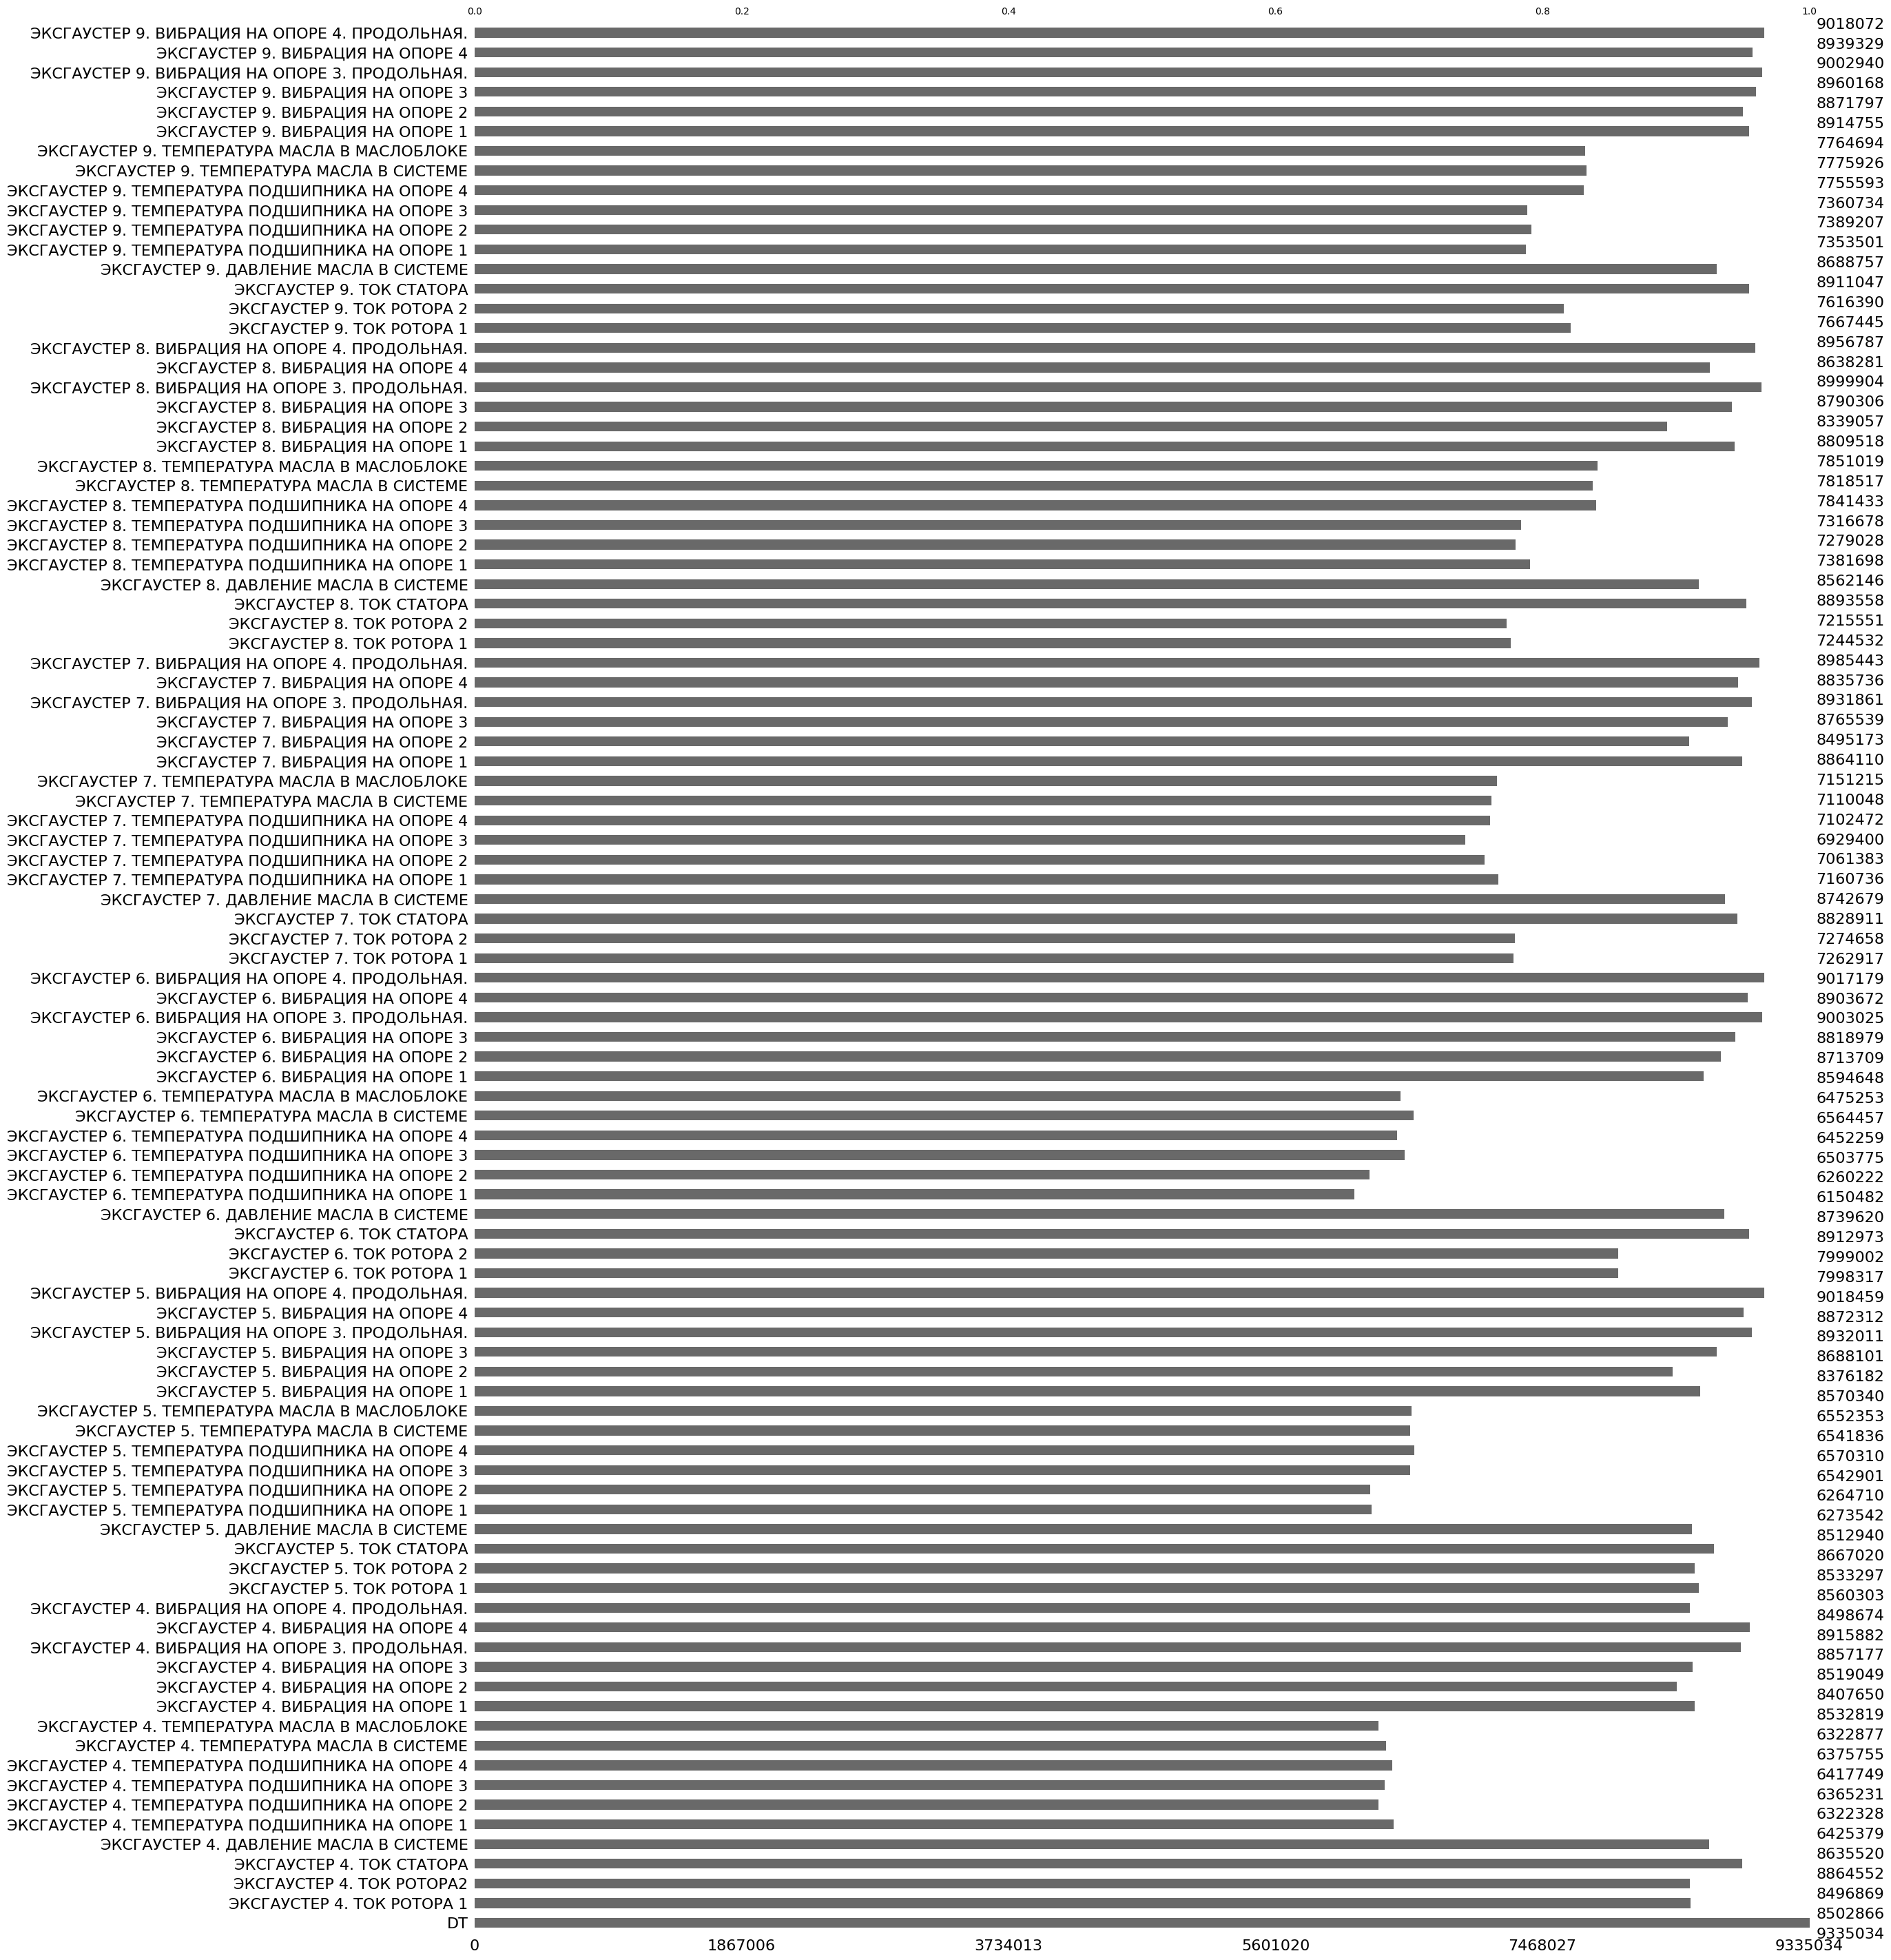

In [9]:
msn.bar(df)

Существует большое количество NaNs. Нам нужно будет как-то справиться с ними позже. А пока давайте выберем случайную машину для более детального анализа.

In [10]:
x_train_c = [column for column in df.columns if column.find("ЭКСГАУСТЕР 5") != -1]
x_train_c

['ЭКСГАУСТЕР 5. ТОК РОТОРА 1',
 'ЭКСГАУСТЕР 5. ТОК РОТОРА 2',
 'ЭКСГАУСТЕР 5. ТОК СТАТОРА',
 'ЭКСГАУСТЕР 5. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ',
 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 1',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 2',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4',
 'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.']

In [11]:
y_train_c = [column for column in y_train.columns if column.find("Y_ЭКСГАУСТЕР А/М №5") != -1]
y_train_c

['Y_ЭКСГАУСТЕР А/М №5_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_КОРПУС ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ЗАДВИЖКА ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (РЕЗ.) ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.1',
 'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.3',
 'Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №5',
 'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.2',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №5_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №5_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №5',
 'Y_ЭКСГАУСТЕР А/М №5_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №5',
 'Y_ЭКСГАУСТЕР А/М №5_ГСМ ЭКСГ. №5',
 'Y_ЭКСГАУСТ

In [12]:
df[x_train_c].head()

,ЭКСГАУСТЕР 5. ТОК РОТОРА 1,ЭКСГАУСТЕР 5. ТОК РОТОРА 2,ЭКСГАУСТЕР 5. ТОК СТАТОРА,ЭКСГАУСТЕР 5. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
0,1.085000,1.085000,110.894997,126.044998,28.389999,33.259998,34.070000,37.320000,26.770000,26.770000,0.030000,0.030000,0.060000,0.100000,0.050000,0.110000
1,1.026476,1.026476,110.894089,126.346664,28.637720,33.180820,34.073212,37.399399,26.690681,25.959999,0.038194,0.043403,0.070312,0.093750,0.078125,0.112847
2,1.036844,1.036844,110.860336,126.144539,28.394341,32.991528,34.253490,37.318272,26.771809,26.681667,0.032793,0.039545,0.072338,0.089699,0.064622,0.116705
3,0.964265,0.964265,110.876732,126.157402,28.556593,33.018570,34.073212,37.156017,26.609552,26.447296,0.030382,0.037326,0.071181,0.086806,0.065972,0.107639
4,0.995370,0.995370,110.876732,126.099998,29.209999,33.018570,34.154335,37.237144,26.690681,26.528423,0.032986,0.038194,0.077257,0.092014,0.065104,0.117188


In [13]:
y_train[y_train_c].head()

,Y_ЭКСГАУСТЕР А/М №5_МАСЛООХЛАДИТЕЛЬ М-05-1 ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_КОРПУС ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ЗАДВИЖКА ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №2,Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (РЕЗ.) ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.1,Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.3,...,Y_ЭКСГАУСТЕР А/М №5_РОТОР ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ.№5,Y_ЭКСГАУСТЕР А/М №5_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №5,Y_ЭКСГАУСТЕР А/М №5_КОЖУХ МУФТЫ ЭКСГ. №5,Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ2,Y_ЭКСГАУСТЕР А/М №5_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2,Y_ЭКСГАУСТЕР А/М №5_ДВИГАТЕЛЬ РЕЗЕРВНОГО МАСЛОНАСОСА ЭКСГ.№5,Y_ЭКСГАУСТЕР А/М №5_ТСМТ-101-010-50М-200 ТЕРМОПР.ПОДШ.Т.3,Y_ЭКСГАУСТЕР А/М №5_ЭКСГАУСТЕР Н-8000 А/М №5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at correlation matrix

<Axes: >

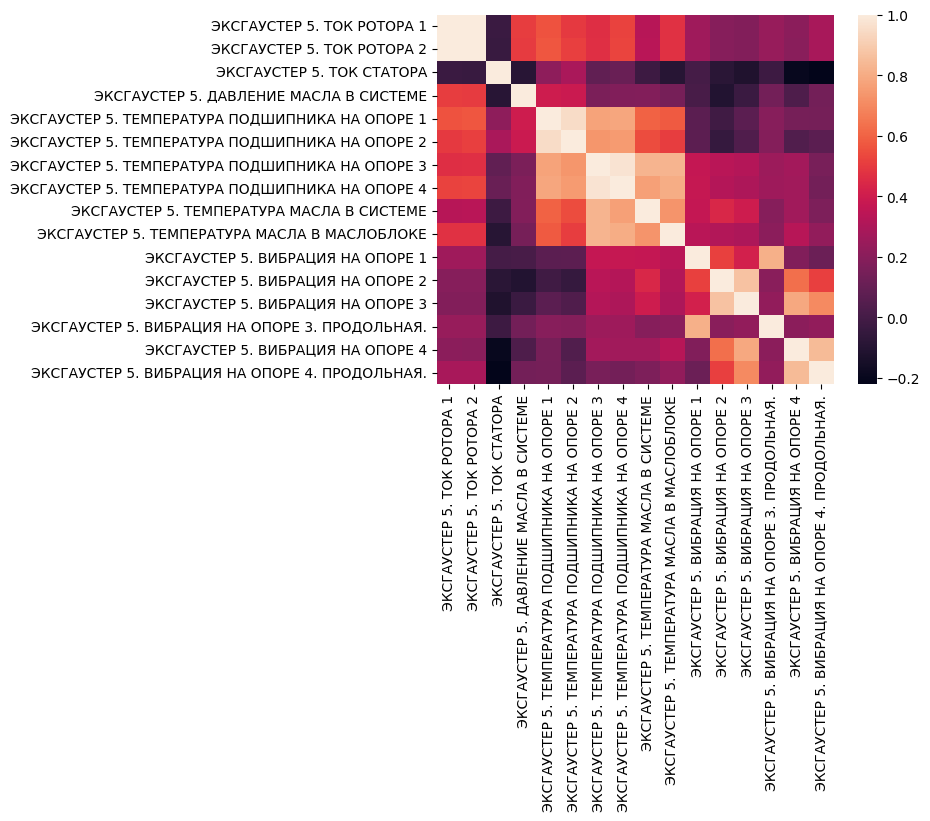

In [15]:
sns.heatmap(df[x_train_c].corr())

Как и ожидалось, некоторые переменные сильно коррелируют. Теперь проверим гистограммы характеристик. Для упрощения расчетов сгруппируем данные по 1 часу. Также нам нужно добавить обратно столбец DT.

In [17]:
x_train_c.insert(0, 'DT')
y_train_c.insert(0, 'Dt')

In [19]:
x_train = df[(df.DT < pd.to_datetime("2020-01-16 13:21"))][x_train_c]
x_train = x_train.groupby(pd.Grouper(freq='1h', key='DT')).median()

In [ ]:
num_features = len(x_train_c[1:])
num_rows = int(num_features / 4) + (num_features % 4 > 0)
num_cols = 4

# Create subplots with calculated rows and columns
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=x_train_c[1:])

# Iterate over each feature and add histogram and violin plot to the respective subplot
for i, feature in enumerate(x_train_c[1:]):
    # Calculate the subplot position
    row_pos = int(i / num_cols) + 1
    col_pos = (i % num_cols) + 1

    # Add histogram to the current subplot
    fig.add_trace(go.Histogram(x=x_train[feature], name=feature, histnorm='probability density'), row=row_pos, col=col_pos)
    # Add violin plot to the current subplot
    #fig.add_trace(go.Violin(y=temp[feature], name=feature, box_visible=True, meanline_visible=True), row=row_pos, col=col_pos)

# Update layout and display the figure
fig.update_layout(height=400 * num_rows, width=600 * num_cols, showlegend=False)
fig.show()


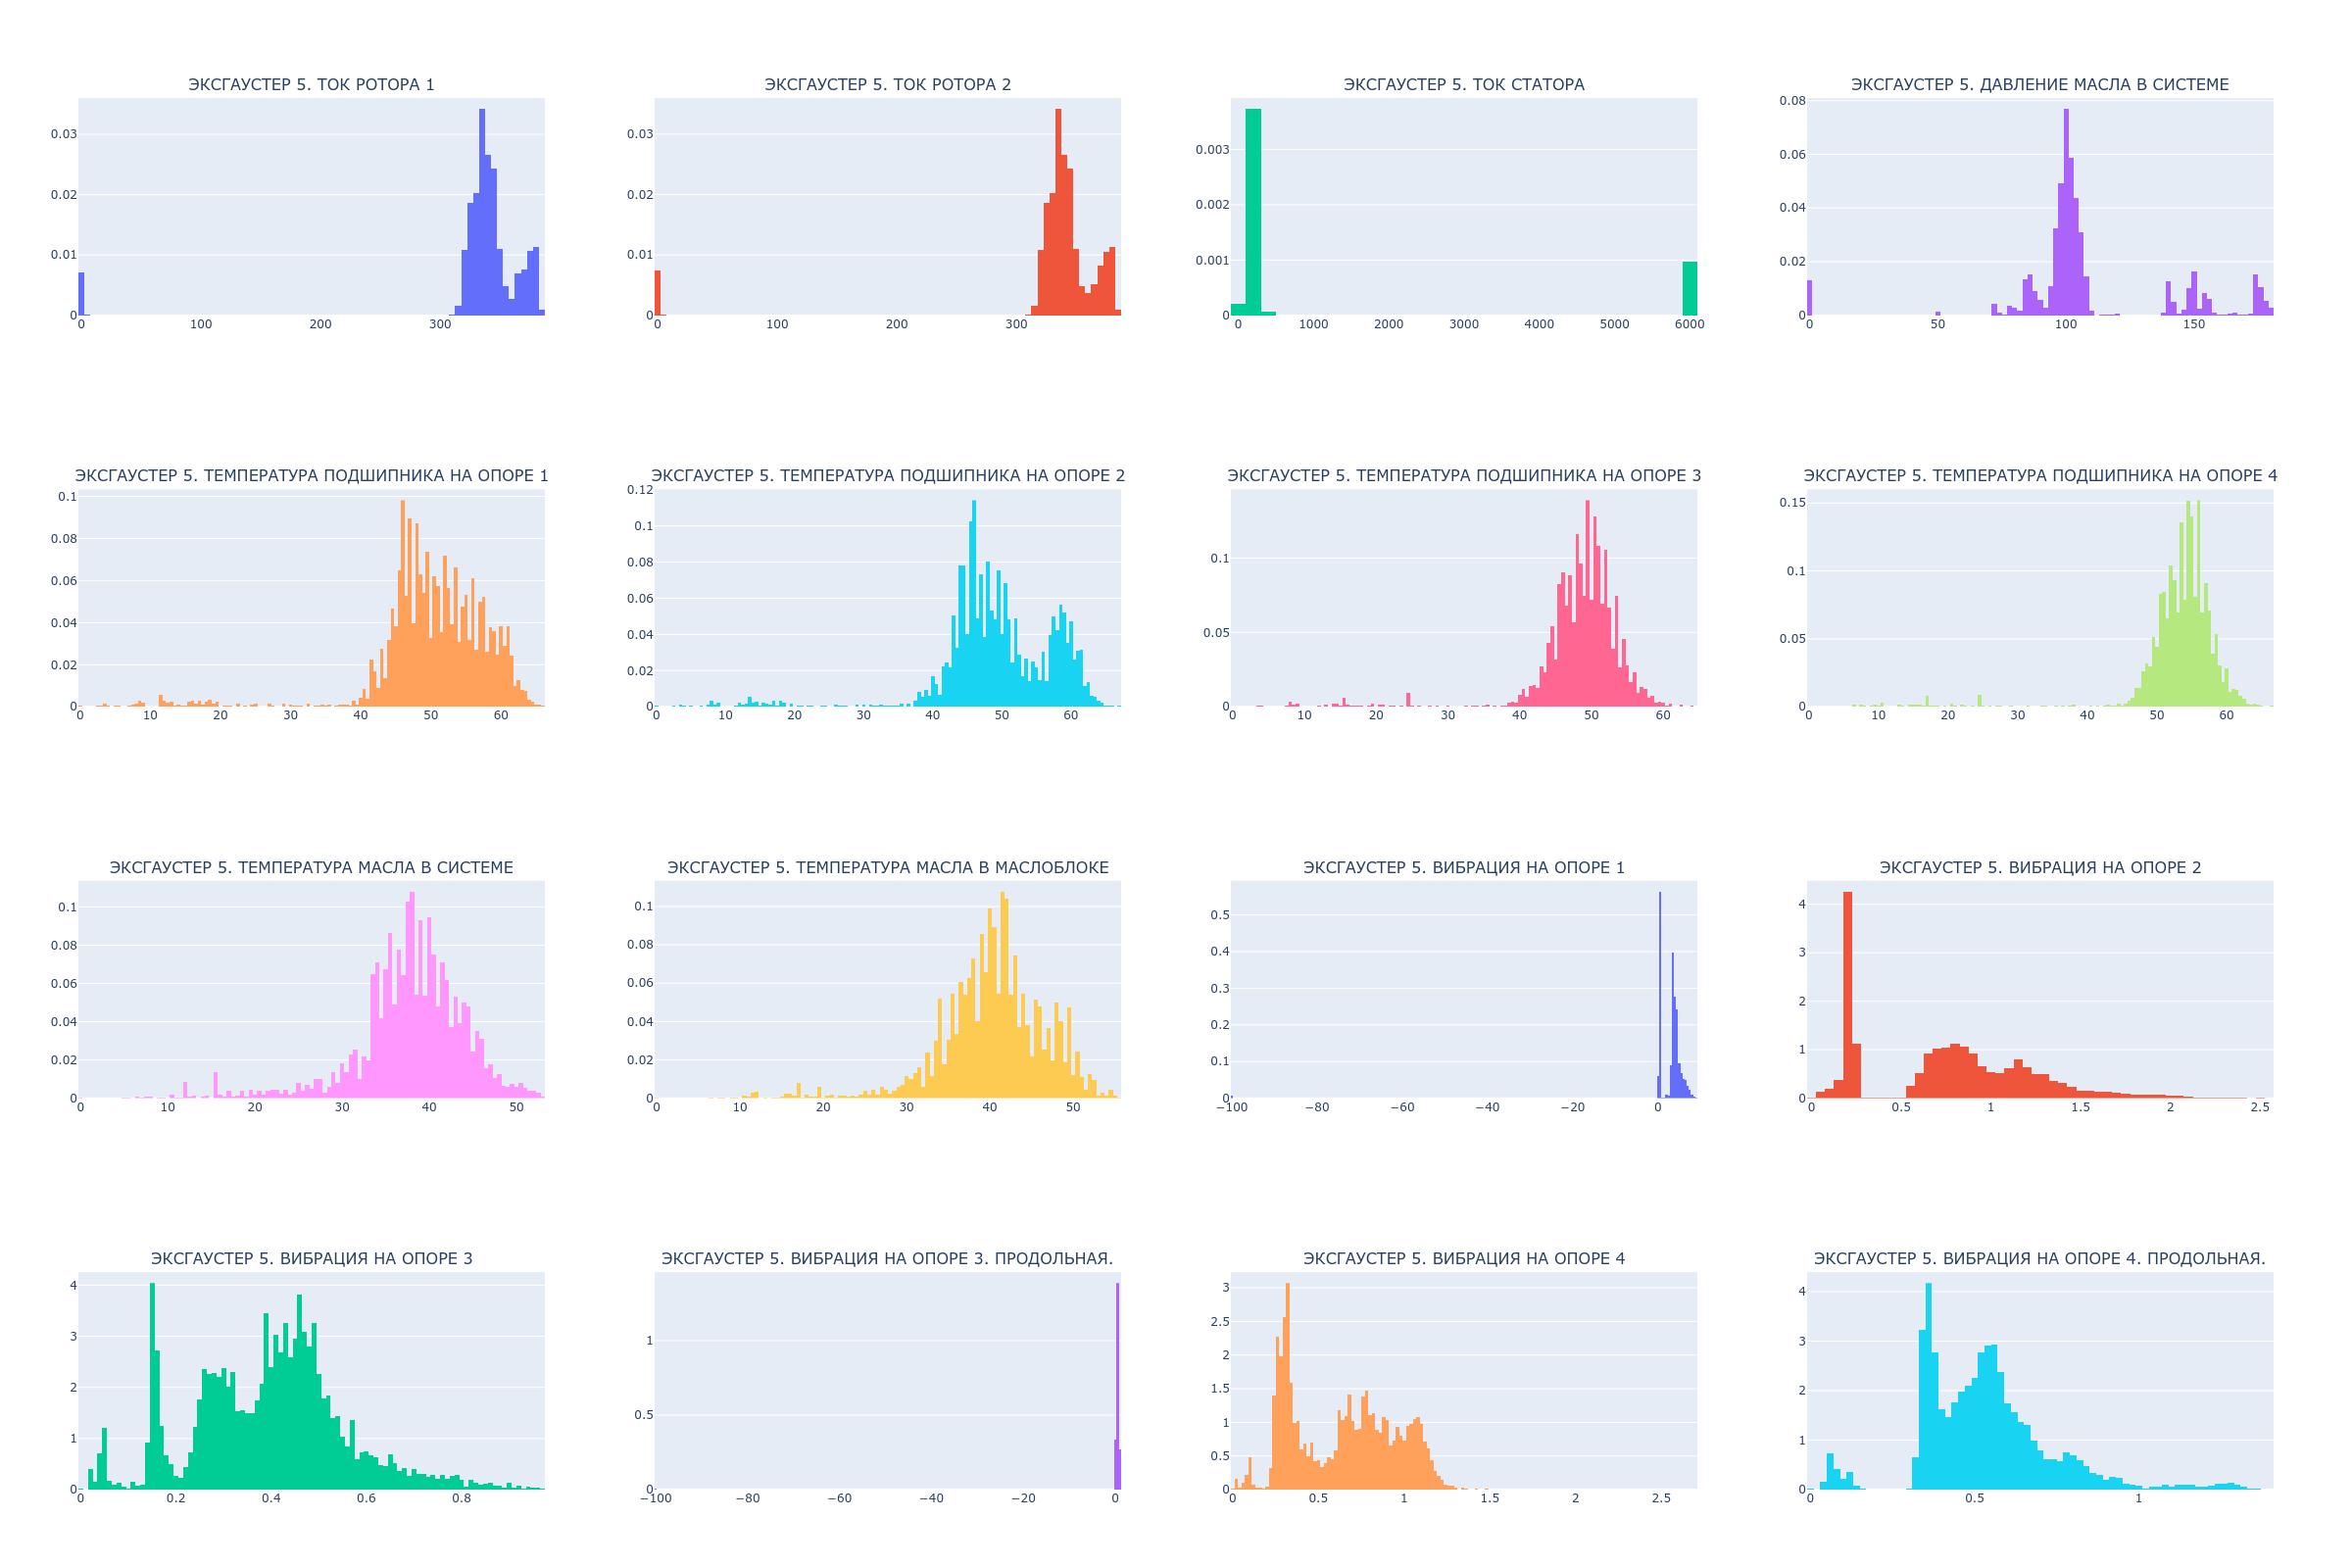

Мы видим, что данные имеют большой перекос. Построим график для каждой характеристики по отдельным годам.

In [ ]:
fig = make_subplots(rows=16, cols=1, subplot_titles=x_train_c[1:])

for i, column in enumerate(x_train_c[1:]):
    fig.add_trace(go.Scatter(x=x_train.index, y=x_train[column], name=column), row=i+1, col=1)

# Update layout
fig.update_layout(height=4000, width=1200, title_text="Plot")
fig.update_xaxes(title_text="Time", row=15, col=1)
fig.update_yaxes(title_text="Value", row=8, col=1)

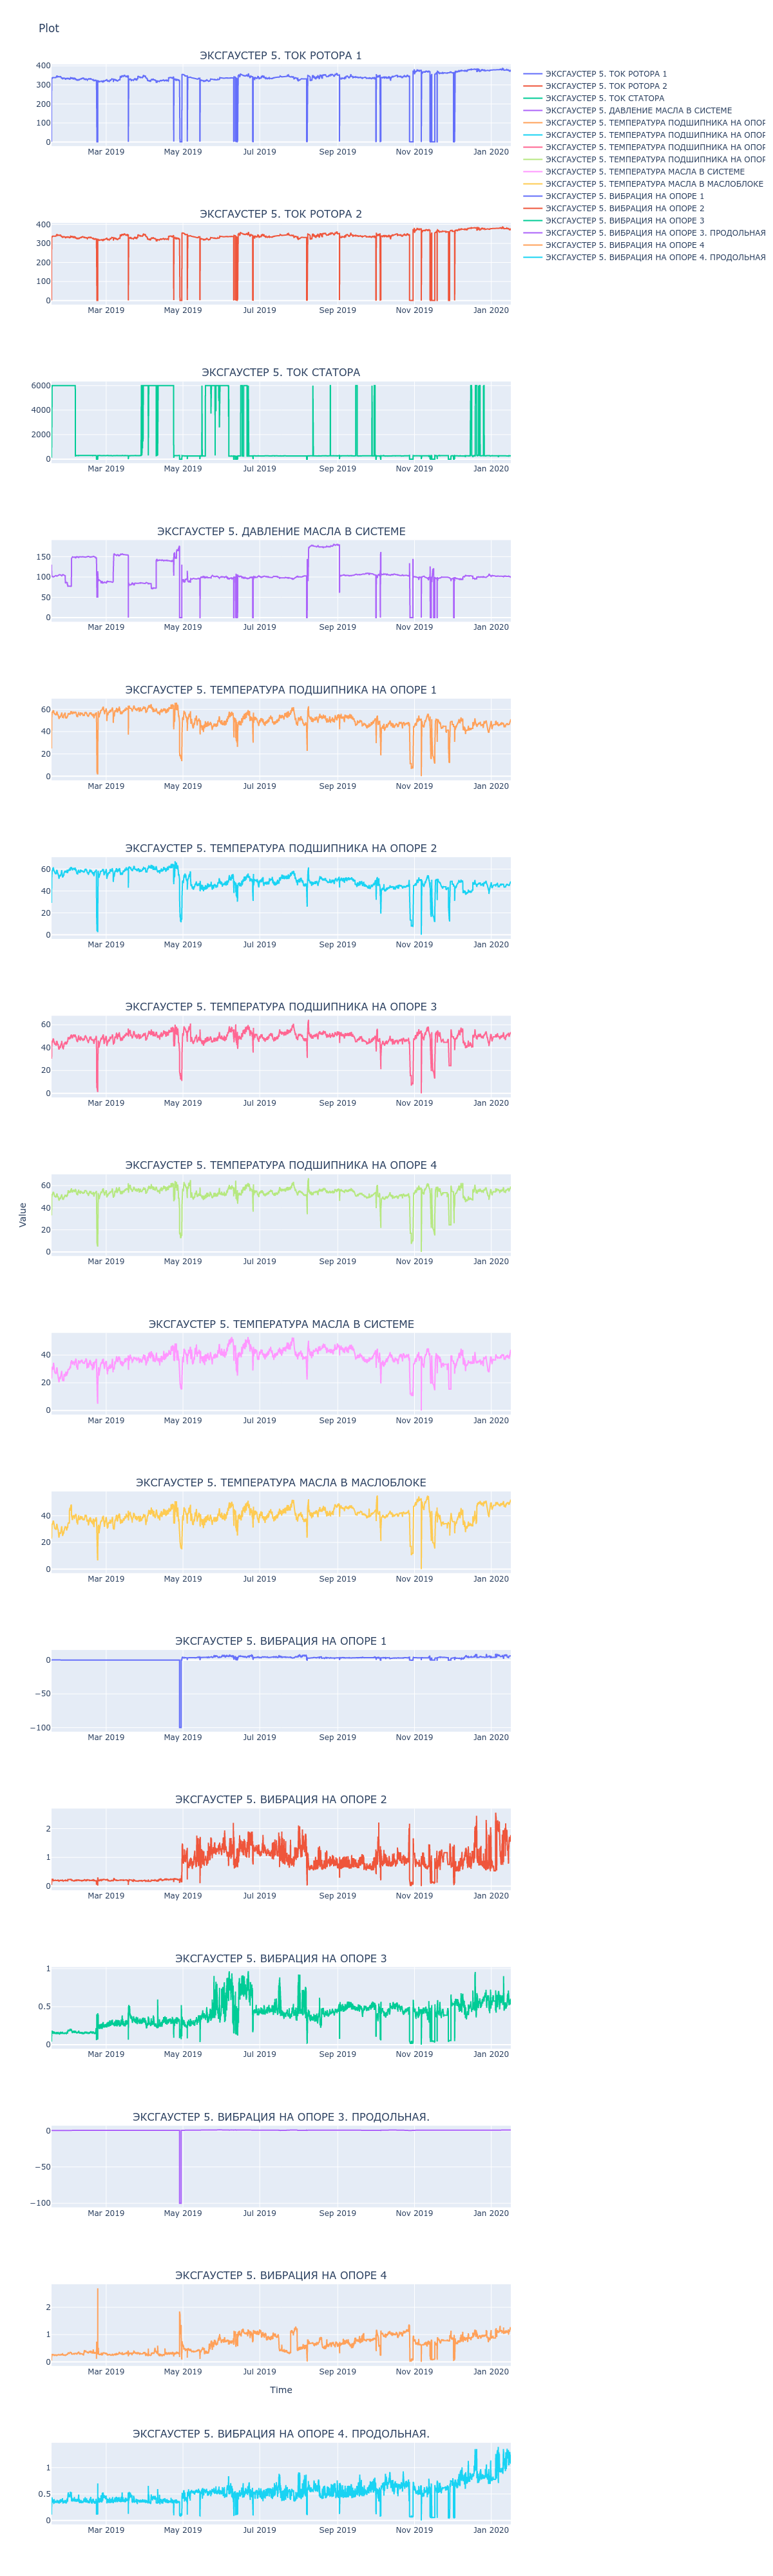

Теперь построим график распределения классов для этой машины.

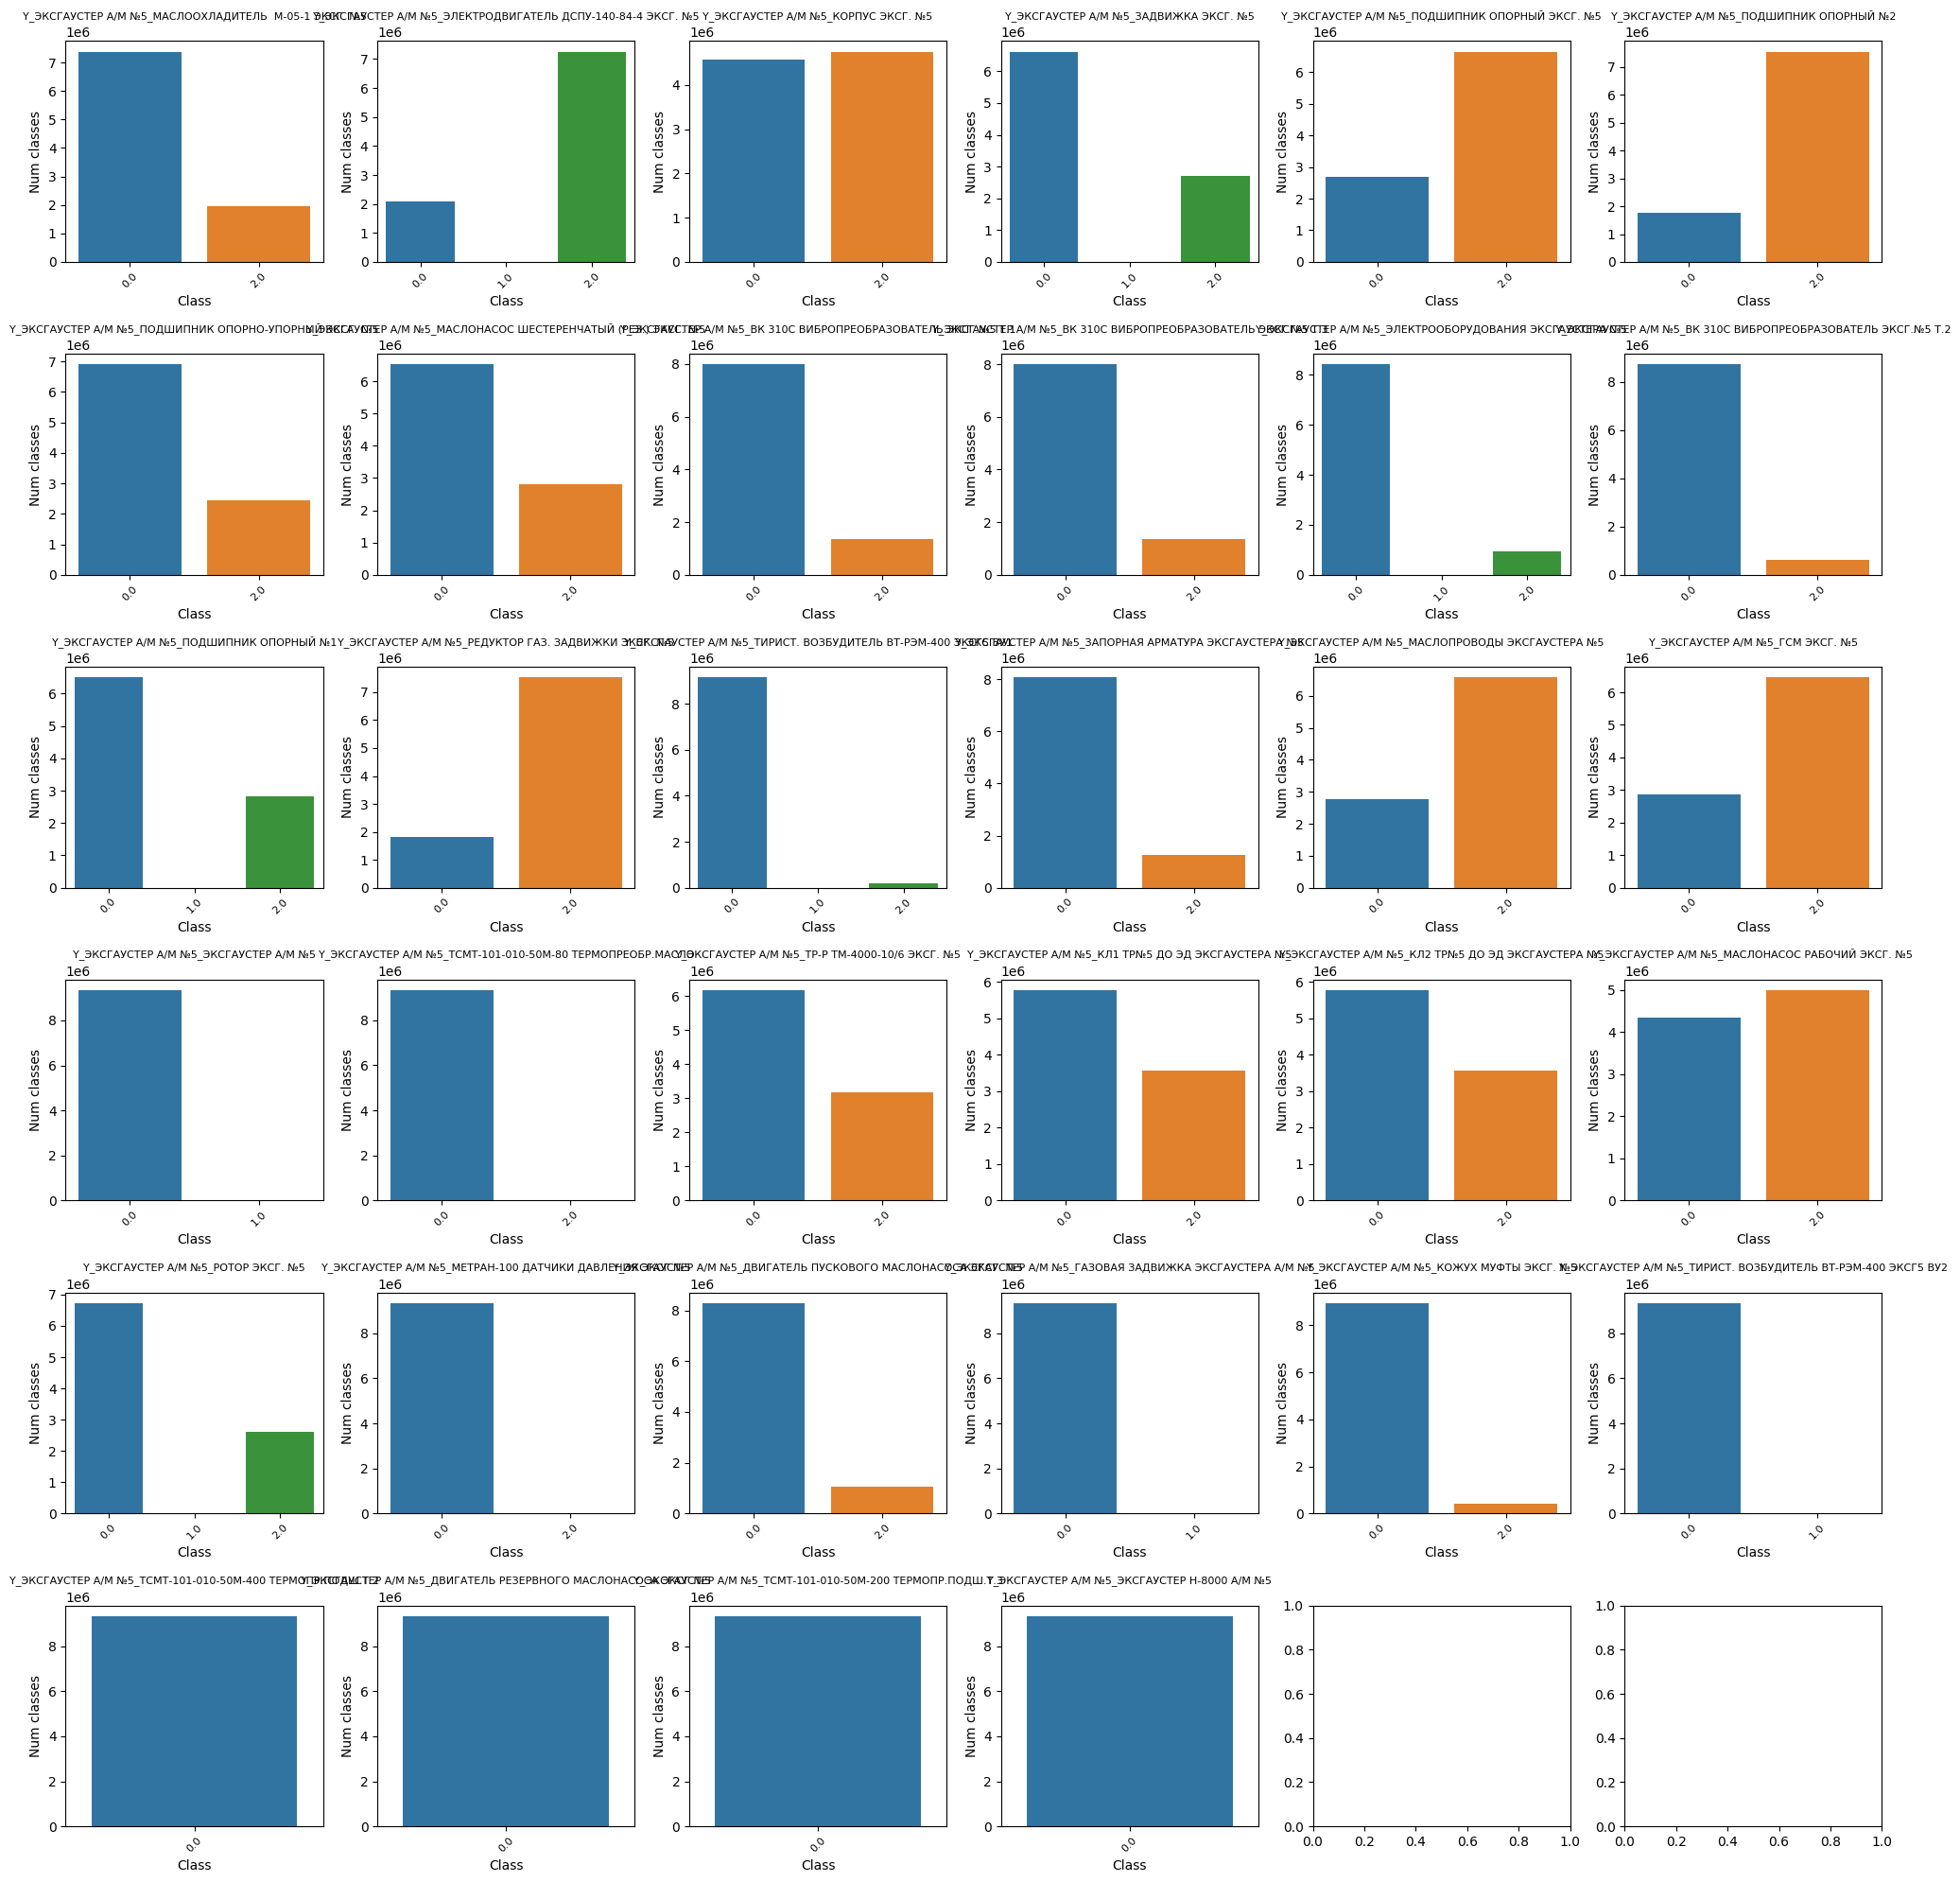

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
axes = axes.ravel()

for i, column in enumerate(y_train_c[1:]):
    ax = axes[i]
    sns.countplot(x=column, data=y_train, ax=ax)
    ax.set_title(column, fontsize=8)
    ax.set_xlabel('Class')
    ax.set_ylabel('Num classes')
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

Как мы видим, некоторые классы вообще не имеют M3 или M1, некоторые из них имеют более длительные периоды работы с M3, чем работы без ошибок. А количество М1 действительно мизерное, по сравнению с другими данными.

Поскольку в реальной ситуации у нас не будет свежих показаний датчиков, для работы модели CatBoost нам необходимо их предсказать. Для этого была выбрана модель TFT, TemporalFusionTransformer. Она может работать с многовариантными, многогрупповыми данными с многогоризонтным прогнозированием. Кроме того, для ее работы не требуется длительная настройка гиперпараметров.

Сначала нам нужно подготовить данные. Для этого сначала сгруппируем их на отрезки по 5 минут и заполним медианными значениями.

In [ ]:
train_data = df.groupby(pd.Grouper(key='DT', freq='5min')).median().ffill().bfill()
target_data = y_train.groupby(pd.Grouper(key='DT', freq='5min')).first()

In [ ]:
train_data.reset_index().to_csv("x_train.csv", index=False)
target_data.reset_index().to_csv("y_train.csv", index=False)

In [31]:
train_data = pd.read_csv("x_train.csv")
target_data = pd.read_csv("y_train.csv")

In [ ]:
# Features for predicting
# ЭКСГАУСТЕР 4
data_4 = train_data.iloc[:,0:16]

# ЭКСГАУСТЕР 5
data_5 = train_data.iloc[:,16:32]

# ЭКСГАУСТЕР 6
data_6 = train_data.iloc[:,32:48]

# ЭКСГАУСТЕР 7
data_7 = train_data.iloc[:,48:64]

# ЭКСГАУСТЕР 8
data_8 = train_data.iloc[:,64:80]

# ЭКСГАУСТЕР 9
data_9 = train_data.iloc[:,80:]

In [ ]:
new_names_features = ['ТОК РОТОРА 1', 
             'ТОК РОТОРА 2',
             'ТОК СТАТОРА', 'ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ',
             'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1',
            'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2',
            'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3',
            'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
            'ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ',
            'ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ',
            'ВИБРАЦИЯ НА ОПОРЕ 1',
            'ВИБРАЦИЯ НА ОПОРЕ 2',
            'ВИБРАЦИЯ НА ОПОРЕ 3',
            'ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.',
            'ВИБРАЦИЯ НА ОПОРЕ 4',
            'ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.']

data_4.columns = new_names_features
data_5.columns = new_names_features
data_6.columns = new_names_features
data_7.columns = new_names_features
data_8.columns = new_names_features
data_9.columns = new_names_features

In [ ]:
new_data = pd.DataFrame(columns = data_5.columns)
target_data = pd.DataFrame(columns = data_5.columns)

for i, data_df in enumerate([data_4, data_5, data_6, data_7, data_8, data_9]):
    data_df['group_col'] = i
    data_df['time_idx'] = data_df.reset_index().index

In [ ]:
for data_df in [data_4, data_5, data_6, data_7, data_8, data_9]:
    
    train_size = int(len(data_df) * 0.985)

    train = data_df.iloc[:train_size]
    test = data_df.iloc[train_size:]
    
    new_data = pd.concat([new_data, train])
    target_data = pd.concat([target_data, test])

Нам нужно удалить ".", поскольку TimeSeriesDataSet не может использовать их в именах столбцов

In [ ]:
for col in new_data.columns:
    new_data = new_data.rename({col: col.replace(".", "")}, axis=1)
    target_data = target_data.rename({col: col.replace(".", "")}, axis=1)

In [ ]:
new_data.time_idx = new_data.time_idx.astype("int32")
target_data.time_idx = target_data.time_idx.astype("int32")

Небольшое пояснение к цифрам. Одна полная неделя (7 дней) - это 24x60/5x7=2016. Теоретически, модель может предсказывать и более длительные периоды, но для этого потребуется больше времени на обучение и более мощный GPU.

На начальном этапе мы обучили первую модель предсказывать только 288 временных шагов (один день), так как это было быстрее, и она показала более высокий SMAPE, но в этом блокноте мы будем использовать только 7-дневную модель. Чтобы обучить свою собственную однодневную модель, вам нужно будет просто уменьшить min и max длину предсказания соответственно.

In [ ]:
training = TimeSeriesDataSet(new_data.reset_index(drop=True), group_ids=['group_col'],
                            target=features,
                            time_idx='time_idx',
                            min_encoder_length=2016,
                            max_encoder_length=2016,
                            min_prediction_length=2016,
                            max_prediction_length=2016,
                            time_varying_unknown_reals=features,
                            add_relative_time_idx=True,
                            allow_missing_timesteps=True)

validation = TimeSeriesDataSet(target_data.reset_index(drop=True), group_ids=['group_col'],
                            target=features,
                            time_idx='time_idx',
                            min_encoder_length=2016,
                            max_encoder_length=2016,
                            min_prediction_length=2016,
                            max_prediction_length=2016,
                            time_varying_unknown_reals=features,
                            add_relative_time_idx=True,
                            allow_missing_timesteps=True)

In [ ]:
batch_size = 6

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=7)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 3, num_workers=7)

In [217]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    gradient_clip_val=0.1,
    max_epochs=15
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=32,
    loss=SMAPE(),
    optimizer="Ranger"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 340.3k


Для метрики мы выбрали SMAPE, так как она более устойчива к выбросам и имеет независимость от масштаба. Прежде чем приступить к обучению нашей модели, давайте найдем оптимальный lr

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 4.933024808050627e-06
Restoring states from the checkpoint path at /home/lightdashing/dev/LTC2023/.lr_find_b31aad75-ba2d-4c22-b460-2a67fa04ab02.ckpt
Restored all states from the checkpoint at /home/lightdashing/dev/LTC2023/.lr_find_b31aad75-ba2d-4c22-b460-2a67fa04ab02.ckpt


suggested learning rate: 4.933024808050627e-06


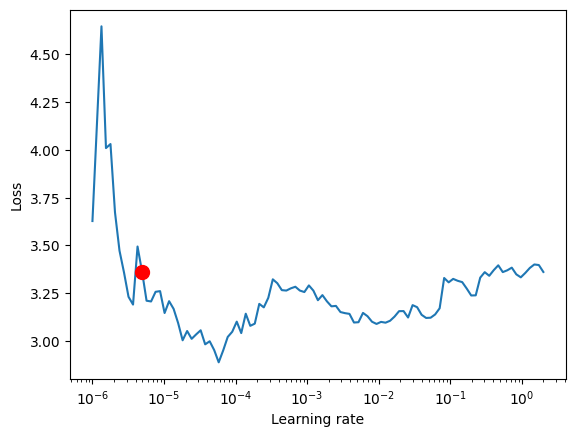

/tmp/ipykernel_86202/459422710.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [218]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=2,
    min_lr=1e-6,
    num_training=100
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [ ]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=2,
    min_lr=1e-6,
    num_training=100
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min", strict=True)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")
saver = ModelCheckpoint(monitor='val_loss', save_top_k=1, every_n_epochs=1)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    # fast_dev_run=True,  # comment in to do fast check
    callbacks=[lr_logger, saver, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=64,
    learning_rate=4.9e-6,
    attention_head_size=4,
    dropout=0.3,
    loss=SMAPE(),
    hidden_continuous_size=32,
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=6,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
torch.set_float32_matmul_precision('medium')

In [39]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    ckpt_path="lightning_logs/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt"
)

Restoring states from the checkpoint path at lightning_logs/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt
/home/lightdashing/miniconda3/envs/lmtc2023/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from 'lightning_logs/lightning_logs/version_11/checkpoints' to 'lightning_logs/lightning_logs/version_13/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lightdashing/miniconda3/envs/lmtc2023/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Построение модели для классификации ошибки М1

### Строим классификацию по принципу OneVsAll 

Для этого сформируем два датасета и обучим два классификатора 

#### Формирование датасета для классификации М1 ошибки

In [ ]:
def bar_plots_target (target_df):

    """Функция построения столючатой диаграммы распределения видов по типам неисправностей

    Args:
        target_df (DataFrame): таргет датафрейм
    """
    try:
        defect_name_list = list(target_df.columns) # Список определяемых дефектов
    
        # Построение диаграмм
        fig, ax = plt.subplots(ncols=3, nrows=round(len(defect_name_list)/3), figsize=(25,len(defect_name_list)))
        for i,j in zip(range(round(len(defect_name_list)/3)), range(0,len(defect_name_list),3)):
            bar_data = target_df.iloc[:,j].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][0]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j])
            del bar_data

            bar_data = target_df.iloc[:,j+1].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][1]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j+1])
            del bar_data

            bar_data = target_df.iloc[:,j+2].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][2]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j+2])
            del bar_data

        plt.tight_layout()
        plt.show()
    except IndexError: 
        print('Количество ячеек больше количества графиков')

In [ ]:
# Заменить все 2 (М3) на 0 
target_data = target_data.replace(2, 0)

In [ ]:
# Построим столбчатые диаграммы распределения видов и типов неисправностей 
bar_plots_target(target_data)

In [ ]:
# Удалим лишние столбцы из messages
messages.drop(columns = ['Unnamed: 0', 'ТЕКСТ_ГРУППЫ_КОДОВ'], inplace = True)


# Создадим новый призкак "Время ремонта" в секундах
messages['Время ремонта'] = (messages['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'] - messages['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'])
messages['Время ремонта'] = messages['Время ремонта'].dt.total_seconds()

In [ ]:
# Выберем из messages сообщения об М1
messages_M1 = messages[messages['ВИД_СООБЩЕНИЯ'] == 'M1']

In [ ]:
target_data = target_data.reset_index()

In [ ]:
# Сформируем таргет датасет в котором будут содержаться отметки с М1

target_data_M1 = pd.DataFrame()
for i in tqdm(range(len(messages_M1))):
    filt_1 = (target_data['DT'] <= messages_M1.iloc[i,7].floor('10S') + pd.to_timedelta('10 sec'))
    filt_2 = (target_data['DT'] >= (messages_M1.iloc[i, 6].floor('10S')+ pd.to_timedelta('10 sec')) - pd.to_timedelta('3 hour'))
    target_data_M1 = target_data_M1.append(target_data[filt_1 & filt_2])

del filt_1
del filt_2

In [ ]:
target_data_M1 = target_data_M1.drop_duplicates()
target_data_M1.shape

In [ ]:
# Установим DT как индекс
target_data_M1 = target_data_M1.set_index('DT')

In [ ]:
def del_col_with_only_zero (df):
    """ Удалим таргеты, состоящиет только из нулей

    Args:
        df (pd.DataFrame()): таргейт датафрейм
        
    return:
        df (pd.DataFrame()): таргет датафрейм без таргетов, состоящих только из нулей
    """
    drop_col_list = []
    for col in df.columns.tolist():
        if (sum(df[col].value_counts().index) == 0):
            drop_col_list.append(col)

    df.drop(columns = drop_col_list, axis = 1, inplace = True)
    return df

In [ ]:
# Удалим в таргете некоторые столбцы 
target_data_M1 = del_col_with_only_zero(target_data_M1)
target_data_M1.shape

In [ ]:
bar_plots_target(target_data_M1)

In [ ]:
# Сбросим индексы
train_data = train_data.reset_index()
target_data_M1 = target_data_M1.reset_index()

In [ ]:
# Объединим в один датафрейм по времени
dataset = train_data.merge(target_data_M1, how = 'inner', on = 'DT')
dataset.shape

In [ ]:
# Разедлим датасет на трейн и таргет
train = dataset.iloc[::,1:97]
target = dataset.iloc[::,97:]

In [ ]:
# Переведем таргет в category
for col in target.columns:
    target[col] = target[col].astype('category')

In [ ]:
# Раздели выборки на трейн, тест и валидацию
X_train, X_validation, y_train, y_validation = train_test_split(train, target, train_size = 0.8, random_state = 45)
X_train, X_test, y_train, y_test = train_test_split(train, target, train_size = 0.8, random_state = 42)

#### Обработка трейна

Пропуски

In [ ]:
# Количество пропусков в трейне
X_train.isna().sum().sum()

In [ ]:
# Обработаем пропуски, заполнив их следующим или предыдущим значением
X_train = X_train.fillna(method='ffill').fillna(method='bfill')

In [ ]:
# Количество пропусков в трейне
X_train.isna().sum().sum()

Мультикорреляция

In [ ]:
def list_multicorr_features (features_data):
    
    """Возвращает список мультикоррелированных фичей
    Args:
        features_data (DataFrame): Датафрейм
    """
    # находим корреляционную матрицу
    corr_matrix = features_data.corr().abs()

    # создаем маску для отбора признаков с корреляцией >0.95
    mask = (corr_matrix > 0.95)

    # находим список признаков с корреляцией > 0.95
    return corr_matrix.columns[mask.any()].tolist()

In [ ]:
multi_corr_feature_4 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 4'))
print(multi_corr_feature_4)

multi_corr_feature_5 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 5'))
print(multi_corr_feature_5)

multi_corr_feature_6 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 6'))
print(multi_corr_feature_6)

multi_corr_feature_7 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 7'))
print(multi_corr_feature_7)

multi_corr_feature_8 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 8'))
print(multi_corr_feature_8)

multi_corr_feature_9 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 9'))
print(multi_corr_feature_9)

In [ ]:
# Выберем фичи для удаления
multi_corr_feature_4 = ['ЭКСГАУСТЕР 4. ТОК РОТОРА2',
                        'ЭКСГАУСТЕР 4. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_5 = ['ЭКСГАУСТЕР 5. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 5. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_6 = ['ЭКСГАУСТЕР 6. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 6. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_7 = ['ЭКСГАУСТЕР 7. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 7. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_8 = ['ЭКСГАУСТЕР 8. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 8. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_9 = ['ЭКСГАУСТЕР 9. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 9. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

In [ ]:
# Удалим из трейна
X_train.drop(columns = multi_corr_feature_4, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_5, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_6, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_7, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_8, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_9, axis = 1, inplace = True)

In [ ]:
# Удалим из валидационного множества
X_validation.drop(columns = multi_corr_feature_4, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_5, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_6, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_7, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_8, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_9, axis = 1, inplace = True)

### Построение модели

In [ ]:
model_defect_M1 = CatBoostClassifier(
    iterations=12000,
    learning_rate=0.02,
    random_seed=42,
    save_snapshot = True,
    snapshot_file = 'model_defect_1_1.bkp',
    snapshot_interval = 60,
    l2_leaf_reg = 3,
    bagging_temperature = 1,
    random_strength = 1,
    leaf_estimation_method = 'Newton',
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 20     
)




model_defect_M1.fit(
    X_train,
    y_train,
    verbose = True,
    use_best_model = True,
    eval_set = (X_validation, y_validation)
)

In [ ]:
model_defect_M1.get_feature_importance(prettified = True)

In [ ]:
y_pred = model_defect_M1.predict(X_test)

In [ ]:
# 'Precision'
precision_dict = {}
values = eval_metric(y_test.values, y_pred, 'Precision')
for cls, value in zip(model_defect_M1.classes_, values):
    precision_dict[cls] = value

#'Recall'
recall_dict = {}
values = eval_metric(y_test.values, y_pred, 'Recall')
for cls, value in zip(model_defect_M1.classes_, values):
    recall_dict[cls] = value

#'F1'
f1_dict = {}
values = eval_metric(y_test.values, y_pred, 'F1')
for cls, value in zip(model_defect_M1.classes_, values):
    f1_dict[cls] = value


# Посчитаем среднее значение метрик по всем таргетам
print(f'Среднее значение метрики Precision -  {np.mean(list(precision_dict.values()))}')
print(f'Среднее значение метрики Recall -  {np.mean(list(recall_dict.values()))}')
print(f'Среднее значение метрики F1 -  {np.mean(list(f1_dict.values()))}')

In [ ]:
print(metrics.classification_report(list(y_test.values[6]), y_pred[6]))

### Подбор гиперпараметров

In [ ]:
import optuna

In [ ]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 1000, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    max_depth = trial.suggest_int('max_depth', 4, 10, step=1)
    leaf_estimation_method = trial.suggest_categorical('leaf_estimation_method',['Newton', 'Gradient'])
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 2.0, 4.0, step=1.0)
    
    # создаем модель
    model = CatBoostClassifier(iterations = iterations,
    learning_rate = learning_rate,
    max_depth = max_depth,
    l2_leaf_reg = l2_leaf_reg,
    leaf_estimation_method = leaf_estimation_method,
    random_state=42,
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 100)
    
    # обучаем модель
    model.fit(X_train, 
    y_train,
    eval_set = (X_validation, y_validation),
    use_best_model = True)
    
    score = np.mean(eval_metric(y_test.values, model.predict(X_test), 'F1'))

    return score

In [ ]:
%time
# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"

study = optuna.create_study(study_name="Catboost", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

In [ ]:
model_defect_M1 = CatBoostClassifier(
    iterations=1600,
    learning_rate=0.06,
    random_seed=42,
    save_snapshot = True,
    #snapshot_file = 'model_defect_1_1.bkp',
    #snapshot_interval = 60,
    l2_leaf_reg = 4,
    max_depth=10,
    bagging_temperature = 1,
    random_strength = 1,
    leaf_estimation_method = 'Gradient',
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 20     
)




model_defect_M1.fit(
    X_train,
    y_train,
    verbose = True,
    use_best_model = True,
    eval_set = (X_validation, y_validation)
)

In [ ]:
model_defect_M1.get_feature_importance(prettified = True)

In [ ]:
y_pred = model_defect_M1.predict(X_test)

In [ ]:
# 'Precision'
precision_dict = {}
values = eval_metric(y_test.values, y_pred, 'Precision')
for cls, value in zip(model_defect_M1.classes_, values):
    precision_dict[cls] = value

#'Recall'
recall_dict = {}
values = eval_metric(y_test.values, y_pred, 'Recall')
for cls, value in zip(model_defect_M1.classes_, values):
    recall_dict[cls] = value

#'F1'
f1_dict = {}
values = eval_metric(y_test.values, y_pred, 'F1')
for cls, value in zip(model_defect_M1.classes_, values):
    f1_dict[cls] = value


# Посчитаем среднее значение метрик по всем таргетам
print(f'Среднее значение метрики Precision -  {np.mean(list(precision_dict.values()))}')
print(f'Среднее значение метрики Recall -  {np.mean(list(recall_dict.values()))}')
print(f'Среднее значение метрики F1 -  {np.mean(list(f1_dict.values()))}')

In [ ]:
#Сохранение модели
model_defect_M1.save_model('model_detect_defect_m1_1_best.bin')
model_defect_M1.save_model('model_detect_defect_m1_1_best.json', format = 'json')

### Построение модели для классификации ошибки М3

Построение этой модели происходит аналогичным образом как и построение модели для классификации ошибки М3, только с заменой целевых значений для М3 с 2 на 1 и заменой целевых значений для М1 с 1 на 0.